In [1]:
import numpy as np
import pandas as pd
import sklearn
import random
from random import sample
from statistics import mean
from scipy.stats import skew
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, zero_one_loss

In [2]:
df = pd.read_csv('HAM10000_metadata.csv')
df.head()
# df = df[df['dx']!='nv']
df['sex'] = df['sex'].astype('category')
df['dx'] = df['dx'].astype('category')

local_dmy = pd.get_dummies(df["localization"])
df_new = pd.concat([df, local_dmy], axis=1)
df_new.drop(columns = ["localization", "lesion_id", "image_id", "dx_type"], inplace=True)

df_new["sex"] = df['sex'].cat.codes
df_new["dx"] = df['dx'].cat.codes

In [3]:
df_new.fillna(round(mean(df_new['age']), -1), inplace=True)

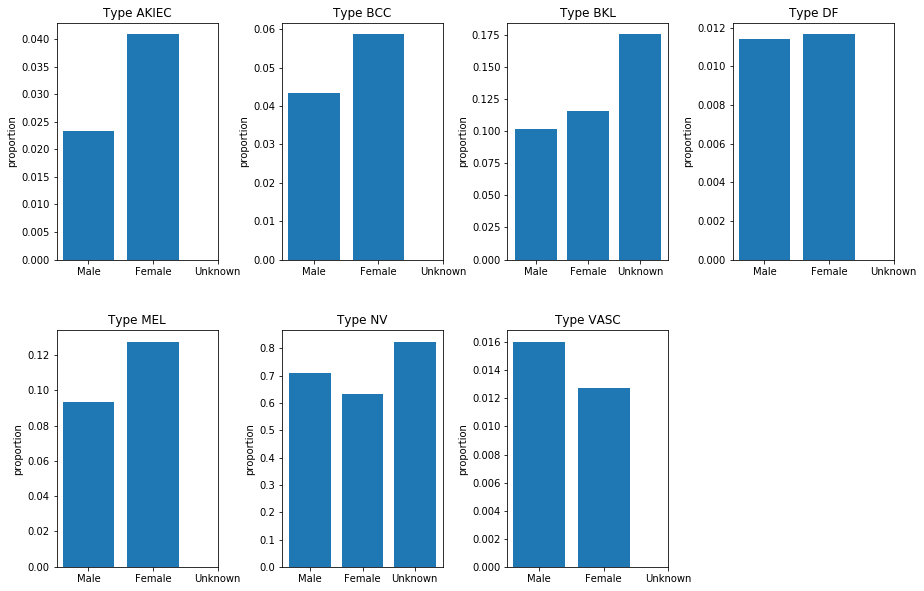

In [4]:
cancer_types = sorted(df['dx'].unique())
agex = sorted(df['sex'].unique())
total_age = df_new.groupby('sex').count()['dx']
plt.figure(figsize=(15, 10))
for i in range(7):
    plt.subplot(2, 4, 1+i)
    plt.subplots_adjust(wspace = 0.4, hspace = .3)
    age = df_new[df_new['dx']==i].groupby('sex').count()['dx']
    age_prop = [age[age.index[j]]/total_age[age.index[j]] for j, _ in enumerate(age)]
    plt.bar(age.index, age_prop)
    plt.title("Type " + cancer_types[i].upper())
#     plt.xlabel("Gender")
    plt.ylabel("proportion")
    plt.xticks(np.arange(3), ('Male', 'Female', 'Unknown'))
plt.savefig('gender_cancer.png')
plt.show()
    

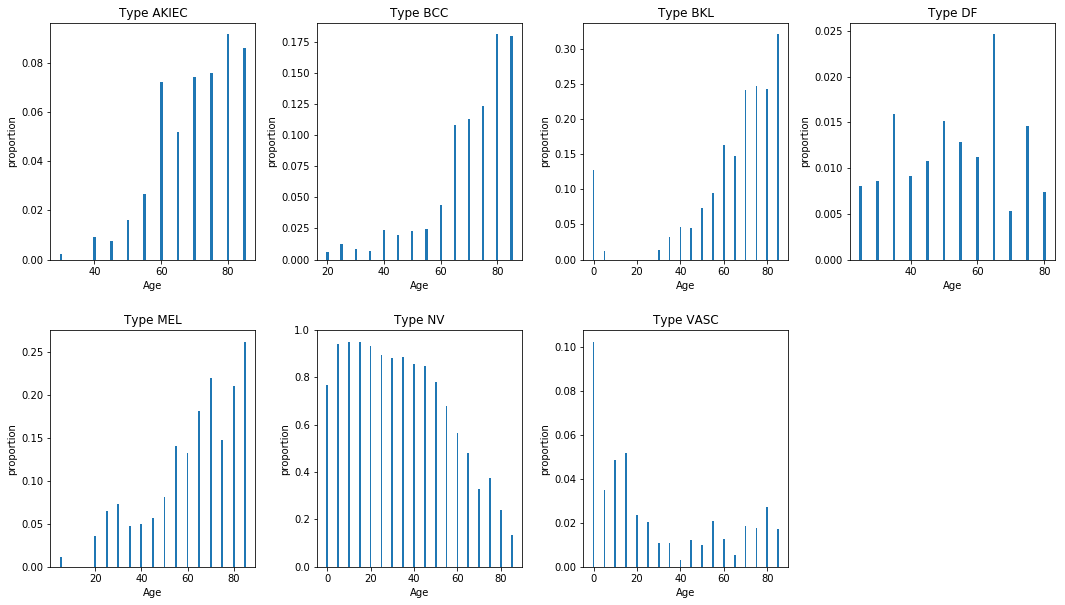

In [5]:
cancer_types = sorted(df['dx'].unique())
agex = sorted(df['age'].unique())
total_age = df_new.groupby('age').count()['dx']
plt.figure(figsize=(18, 10))
for i in range(7):
    plt.subplot(2, 4, 1+i)
    plt.subplots_adjust(wspace = 0.3, hspace=.3)
    age = df_new[df_new['dx']==i].groupby('age').count()['dx']
    age_prop = [age[age.index[j]]/total_age[age.index[j]] for j, _ in enumerate(age)]
    plt.bar(age.index, age_prop)
    plt.title("Type " + cancer_types[i].upper())
    plt.xlabel("Age")
    plt.ylabel("proportion")
plt.savefig('age_cancer.png')
plt.show()


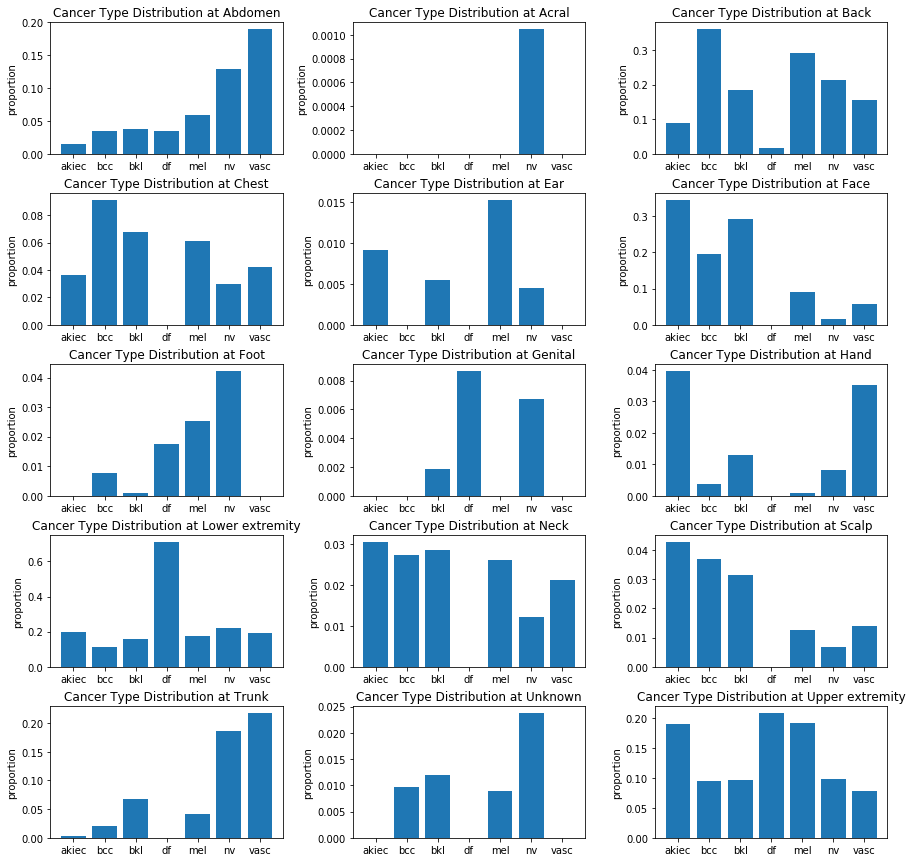

In [6]:
total_dx = df_new.groupby("dx").count()['age']
local_types = sorted(df['localization'].unique())
plt.figure(figsize=(15, 15))
for j, part in enumerate(local_types):
    dx = df_new[df_new[part]==True].groupby("dx").count()['age']
    proportion = []
    for i in range(7):
        if i in dx.index:
            proportion.append(dx[i]/total_dx[i])
        else: 
            proportion.append(0) 
    plt.subplot(5, 3, 1+j)
    plt.subplots_adjust(wspace = 0.3, hspace = 0.3)
    plt.bar(cancer_types, proportion)
    plt.title("Cancer Type Distribution at "+  part.capitalize())
#     plt.xlabel("type")
    plt.ylabel("proportion")
plt.savefig('local_cancer.png')
plt.show()


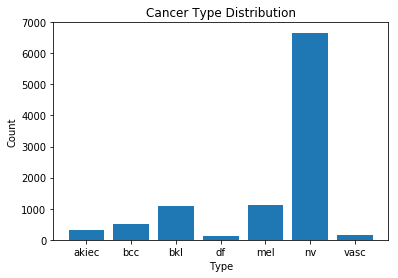

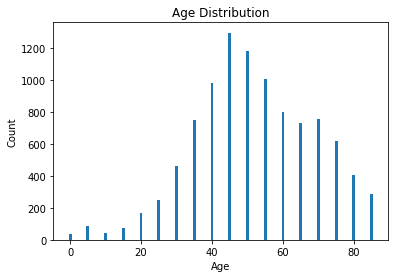

In [7]:
plt.figure(500)
dx = df_new.groupby("dx").count()['age']
plt.bar(cancer_types, dx)
plt.title("Cancer Type Distribution")
plt.xlabel("Type")
plt.ylabel("Count")
plt.show()

plt.figure(500)
age = df_new.groupby("age").count()['dx']
plt.bar(age.index, age)
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

Data Analysis: For the distribution of cancer type for each localization, only the proportion of the cancer type that belongs to a particular location is considered since the majority of the data, around 6000 in the training sample, has classification label melanocytic nevi(nv). The age distribution are shown in terms of proportion also since the mean age among the sample population is around 51.86 consisting mostly of older populations. The age distribution for melanocytic nevi consist of mostly of younger population while the other cancer type tend to be made up of samples from the older population. Cancer type dermatofibroma has a relatively balanced age distribution.


Preprocessing: Dummy variables are generated for each of the locations where the tumors are found. Sex is converted into a binary variable and the type of cancer is converted into categorical variable. Classifiers are trained using Random Forest and Support Vector Machine both use balanced weight for their prediction. Training set consist of 9/10 of the data and test set the rest. RFC uses square root of the number of features for each split as part of model building. Random Forest Classifier scored around 0.54 on training error and 0.55 on test error while SVM scores around 0.56 on training error and 0.58 on test error. Overall training the model on just the sex, age, and location of tumor do not give a high performing result.

In [9]:
random.seed(12345)
train_index = sample(range(len(df_new)), int(9*len(df_new)/10))
test_index = [i for i in range(len(df_new)) if i not in train_index]
df_new.dropna(inplace=True)
df_np = np.array(df_new)
y_train_nv = []
y_train_non = []
y_train = []
x_train_nv = []
x_train = []
for i in train_index:
    if df_np[i][0] == 5:
        y_train_nv.append('nv')
        x_train_nv.append(df_np[i][1:])
    else:
        y_train_non.append('non-nv')
        y_train.append(df_np[i][0])
        x_train.append(df_np[i][1:])

        
y_test_nv = []
y_test_non = []
y_test = []
x_test_nv = []
x_test = []
for i in test_index:
    if df_np[i][0] == 5:
        y_test_nv.append('nv')
        x_test_nv.append(df_np[i][1:])
    else:
        y_test_non.append('non-nv')
        y_test.append(df_np[i][0])
        x_test.append(df_np[i][1:])


clf = RFC(n_estimators=100, max_depth=7, max_features="sqrt", class_weight="balanced")
clf.fit(x_train + x_train_nv, y_train_non + y_train_nv)

err = 0
y_test_total = y_test_non + y_test_nv
pred_test = clf.predict(x_test + x_test_nv)
pred_train = clf.predict(x_train + x_train_nv)
cm_test = confusion_matrix(pred_test, y_test_total)
cm_train = confusion_matrix(pred_train, y_train_non + y_train_nv)
test_err_rfc = zero_one_loss(pred_test, y_test_non + y_test_nv)
train_err_rfc = zero_one_loss(pred_train, y_train_non + y_train_nv)
print("Test Error: ", test_err_rfc, "Training Error: ", train_err_rfc)
for i, val in enumerate(pred_test):
    if y_test_total[i] != val:
        err += 1

Test Error:  0.22289156626506024 Training Error:  0.21780852488283864


In [10]:
random.seed(12345)
clf2 = RFC(n_estimators=100, max_depth=7, max_features="sqrt", class_weight="balanced")
clf2.fit(x_train, y_train)

pred_test = clf2.predict(x_test)
pred_train = clf2.predict(x_train)
cm_test = confusion_matrix(pred_test, y_test)
cm_train = confusion_matrix(pred_train, y_train)
test_err_rfc = zero_one_loss(pred_test, y_test)
train_err_rfc = zero_one_loss(pred_train, y_train)
print("Test Error: ", test_err_rfc, "Training Error: ", train_err_rfc)

Test Error:  0.6646884272997033 Training Error:  0.6673421141506248


In [11]:
further_test = clf.predict(x_test)
further_index = []
for i, val in enumerate(further_test):
    if val == 'non-nv':
        further_index.append(i)
y_test2 = [y_test[i] for i in further_index]
x_test2 = [x_test[i] for i in further_index]
pred_test2 = clf2.predict(x_test2)
for i, val in enumerate(pred_test2):
    if val != y_test2[i]:
        err +=1
print(err/len(y_test_total))

0.3965863453815261


In [ ]:
random.seed(12345)
train_index = sample(range(len(df_new)-3), int(9*len(df_new)/10))
test_index = [i for i in range(len(df_new)) if i not in train_index]
df_new.dropna(inplace=True)
df_np = np.array(df_new)
y_train = [df_np[i][0] for i in train_index]
x_train = [df_np[i][1:] for i in train_index]
y_test = [df_np[i][0] for i in test_index]
x_test = [df_np[i][1:] for i in test_index]
clf = RFC(n_estimators=100, max_depth=7, max_features="sqrt", class_weight="balanced")
clf.fit(x_train, y_train)

pred_test = clf.predict(x_test)
pred_train = clf.predict(x_train)
cm_test = confusion_matrix(pred_test, y_test)
cm_train = confusion_matrix(pred_train, y_train)
test_err_rfc = zero_one_loss(pred_test, y_test)
train_err_rfc = zero_one_loss(pred_train, y_train)
print("Test Error: ", test_err_rfc, "Training Error: ", train_err_rfc)

In [ ]:
non_index = []
for i, val in enumerate(pred_test):
    non_index.append(i)

In [ ]:
random.seed(12345)
train_index = sample(range(len(df_new)-1), int(9*len(df_new)/10))
test_index = [i for i in range(len(df_new)) if i not in train_index]
df_new.dropna(inplace=True)
df_np = np.array(df_new)
y_train = [df_np[i][0] for i in train_index]
x_train = [df_np[i][1:] for i in train_index]
y_test = [df_np[i][0] for i in test_index]
x_test = [df_np[i][1:] for i in test_index]
clf = RFC(n_estimators=100, max_depth=7, max_features="sqrt", class_weight="balanced")
clf.fit(x_train, y_train)

pred_test = clf.predict(x_test)
pred_train = clf.predict(x_train)
cm_test = confusion_matrix(pred_test, y_test)
cm_train = confusion_matrix(pred_train, y_train)
test_err_rfc = zero_one_loss(pred_test, y_test)
train_err_rfc = zero_one_loss(pred_train, y_train)
print("Test Error: ", test_err_rfc, "Training Error: ", train_err_rfc)

In [ ]:
confusion_matrix(pred_test, y_test)

In [ ]:
svm_clf = SVC(C=2, gamma="auto", cache_size=200, class_weight="balanced")
svm_clf.fit(x_train, y_train)
pred_test = svm_clf.predict(x_test)
pred_train = svm_clf.predict(x_train)
cm_test = confusion_matrix(pred_test, y_test)
cm_train = confusion_matrix(pred_train, y_train)
test_err_svm = zero_one_loss(pred_test, y_test)
train_err_svm = zero_one_loss(pred_train, y_train)
print("Test Error: ", test_err_svm, "Training Error: ", train_err_svm)

In [ ]:
cancer_types

In [ ]:
confusion_matrix(pred_test, y_test)

In [ ]:
cm_train